# Surrogate Modelling

This is a test script that models a basic pressure changer unit operation.

It uses idaes to generate some training data, then trains the model on the data to approximate the mathematical model.

After getting this to work well, we can try and get it to simulate a dynamic system.

In [4]:
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Compressor
from idaes.models.properties import iapws95
from idaes.core.util.model_statistics import degrees_of_freedom

m = pyo.ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.properties = iapws95.Iapws95ParameterBlock()
m.fs.unit = Compressor(property_package=m.fs.properties)

m.fs.unit.inlet.flow_mol[0].fix(100)
m.fs.unit.inlet.enth_mol[0].fix(4000)
m.fs.unit.inlet.pressure[0].fix(101325)
m.fs.unit.work_isentropic.fix(10000000)
m.fs.unit.efficiency_isentropic.fix(0.9)

print(f'degrees of freedom: {degrees_of_freedom(m)}')

# Solve the model with a bunch of different values for inlet pressure and temperature and flow

# https://github.com/IDAES/examples-pse/blob/main/src/Examples/SurrMod/PySMO/PySMO_basics.ipynb
from idaes.core.surrogate.pysmo.sampling import HammersleySampling

# define the bounds for the input variables [inlet pressure, inlet temperature, flow]
bounds_info = [[51325, 1000,1],[1013250, 6000,10000]]
init_data = HammersleySampling(data_input=bounds_info, number_of_samples=250, sampling_type="creation")

# run the model for each set of input variables
# store the outlet pressure, temperature in a dataframe
# store the input variables in the same dataframe

import pandas as pd

solver = pyo.SolverFactory('ipopt')

#df = pd.DataFrame(columns=['pressure', 'enthalpy', 'flow', 'outlet_pressure', 'outlet_enthalpy', 'outlet_flow'])
# use numpy arrays instead
import numpy as np
datapoints = []


print("solving")
for [pressure, enth, flow] in init_data.sample_points():
    m.fs.unit.inlet.pressure[0].fix(pressure)
    m.fs.unit.inlet.enth_mol[0].fix(enth)
    m.fs.unit.inlet.flow_mol[0].fix(flow)
    print(f'pressure: {pressure}, enthalpy: {enth}, flow: {flow},')
    solver.solve(m, tee=False)
    print(f'outlet pressure: {pyo.value(m.fs.unit.outlet.pressure[0])}, outlet temperature: {pyo.value(m.fs.unit.outlet.enth_mol[0])}, outlet flow: {pyo.value(m.fs.unit.outlet.flow_mol[0])}')
    datapoints.append([pressure, enth, flow, pyo.value(m.fs.unit.outlet.pressure[0]), pyo.value(m.fs.unit.outlet.enth_mol[0])])
    


degrees of freedom: 0
Sampling type:  creation 

solving
pressure: 51325.0, enthalpy: 1000.0, flow: 1.0,
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
outlet pressure: 1100000000.0, outlet temperature: 80765.34157807352, outlet flow: 137.58514212743566
pressure: 55172.7, enthalpy: 3500.0, flow: 3334.0,
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
outlet pressure: 3718.8901042303833, outlet temperature: 6832.666799973339, outlet flow: 3334.0
pressure: 59020.4, enthalpy: 2250.0, flow: 6667.0,
outlet pressure: 84400849.49763753, outlet temperature: 3916.583337499792, outlet flow: 6667.0
pressure: 62868.1, enthalpy: 4750.0, flow: 1112.0,
outlet pressure: 529642294.0973233, outlet temperature: 14742.006394884093, outlet flow: 

ValueError: Cannot load a SolverResults object with bad status: error

/tmp/ipykernel_152108/2271287337.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


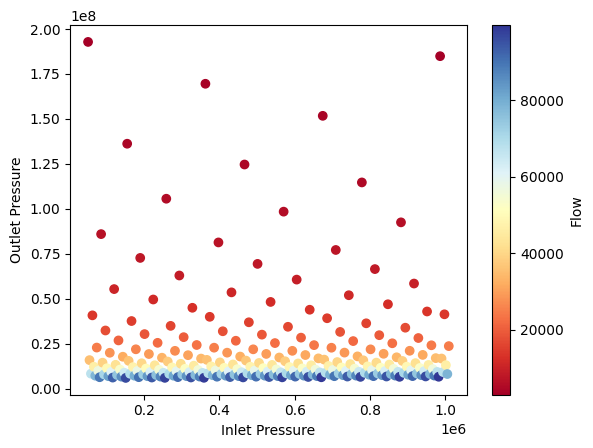

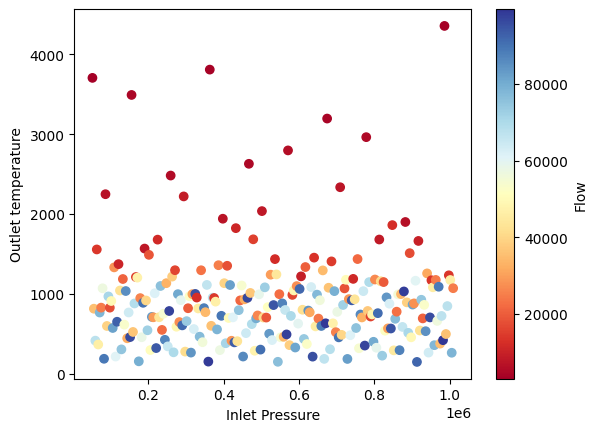

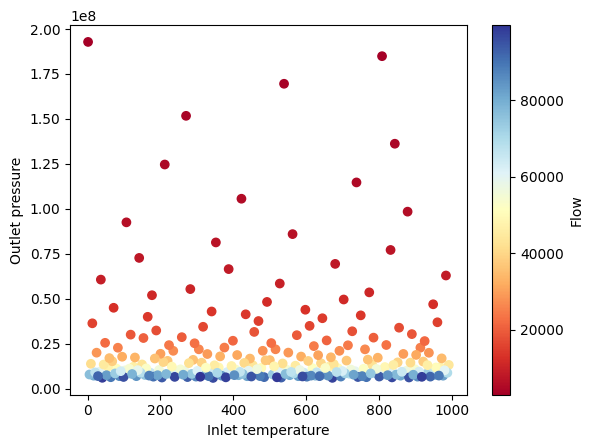

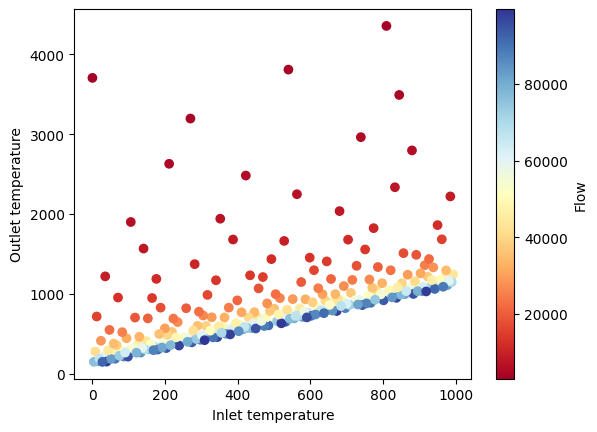

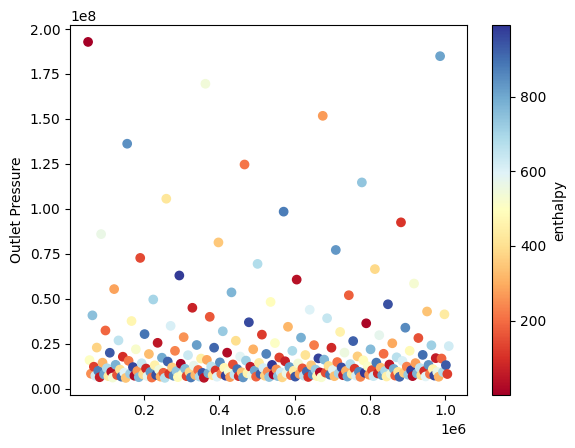

In [ ]:
# plot the results

import matplotlib.pyplot as plt
import seaborn as sns

# scatter plot of the input pressure and temperature vs outlet pressure and temperature
df = pd.DataFrame(datapoints, columns=['pressure', 'enthalpy', 'flow', 'outlet_pressure', 'outlet_enthalpy'])
cm = plt.cm.get_cmap('RdYlBu')
scatter = plt.scatter(df['pressure'], df['outlet_pressure'], c=df['flow'], cmap=cm)
plt.xlabel('Inlet Pressure')
plt.ylabel('Outlet Pressure')
plt.colorbar(scatter, label='Flow')
plt.show()


scatter = plt.scatter(df['pressure'], df['outlet_enthalpy'], c=df['flow'], cmap=cm)
plt.xlabel('Inlet Pressure')
plt.ylabel('Outlet temperature')
plt.colorbar(scatter, label='Flow')
plt.show()

scatter = plt.scatter(df['enthalpy'], df['outlet_pressure'], c=df['flow'], cmap=cm)
plt.xlabel('Inlet temperature')
plt.ylabel('Outlet pressure')
plt.colorbar(scatter, label='Flow')
plt.show()

scatter = plt.scatter(df['enthalpy'], df['outlet_enthalpy'], c=df['flow'], cmap=cm)
plt.xlabel('Inlet temperature')
plt.ylabel('Outlet temperature')
plt.colorbar(scatter, label='Flow')
plt.show()

scatter = plt.scatter(df['pressure'], df['outlet_pressure'], c=df['enthalpy'], cmap=cm)
plt.xlabel('Inlet Pressure')
plt.ylabel('Outlet Pressure')
plt.colorbar(scatter, label='enthalpy')
plt.show()



Looks like there's some polynomial relationships there, maybe polynomialRegression can learn them.

In [ ]:
# Gonna try polynomial regression from pysmo, following https://github.com/IDAES/examples-pse/blob/main/src/Examples/SurrMod/PySMO/PySMO_basics.ipynb



from idaes.core.surrogate.pysmo.polynomial_regression import PolynomialRegression

# we need to make a model to predict outlet pressure
# and another model to predict outlet temperature
# this is because I don't think we can predict two outputs with one model

outlet_temp_data = df.drop(columns=['outlet_pressure'])
outlet_pressure_data = df.drop(columns=['outlet_enthalpy'])

outlet_temp_data
poly_class = PolynomialRegression(original_data_input=outlet_temp_data, regression_data_input=outlet_temp_data, 
                                maximum_polynomial_order=4, multinomials=1, training_split=0.8, number_of_crossvalidations=10, overwrite=True)

vars = poly_class.get_feature_vector()
vars.pprint()
# # we can specify additional terms here, such as x1*x2, x1^2, etc
# #poly_class.set_additional_terms([vars[0] * vars[0] * vars[1] * vars[1], exp(vars[0]), exp(vars[1])])
from pyomo.environ import exp
poly_class.set_additional_terms([vars['enthalpy'] * vars['enthalpy'], vars['pressure'] * vars['pressure'],vars['enthalpy'] * vars['pressure'],vars['flow']*vars['flow'],vars['enthalpy']*vars['flow'],vars['pressure']*vars['flow']])

poly_class.training()



===========================Polynomial Regression===============================================


No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 

IndexedParam : Size=3, Index={pressure, enthalpy, flow}, Domain=Any, Default=None, Mutable=True
    Key      : Value
    enthalpy :     0
        flow :     0
    pressure :     0
No iterations will be run.
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
      Exceeded.
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
      Exceeded.
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
      Exceeded.
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.2\x3a Maximum Numbe

/home/bert/miniconda3/envs/idaes/lib/python3.11/site-packages/idaes/core/surrogate/pysmo/polynomial_regression.py:1517: UserWarning: Polynomial regression generates poor fit for the dataset
  warnings.warn(



Results of polynomial regression run:

Polynomial order                   : 1
Number of terms in polynomial model: 13

Polynomial Expression:
--------------------------

196.92132245460303 + 0.0022661216123599577*IndexedParam[pressure] + 3.0122945644281502*IndexedParam[enthalpy] - 0.030310836794944514*IndexedParam[flow] - 0.8684627900272011*(IndexedParam[enthalpy]*IndexedParam[pressure]) + 0.7046998334668625*(IndexedParam[flow]*IndexedParam[pressure]) - 0.05294866138552258*(IndexedParam[flow]*IndexedParam[enthalpy]) - 0.0008144798050046615*(IndexedParam[enthalpy]*IndexedParam[enthalpy]) - 1.0306706934048992e-09*(IndexedParam[pressure]*IndexedParam[pressure]) + 0.8684619546037569*(IndexedParam[enthalpy]*IndexedParam[pressure]) + 3.028944838350567e-07*(IndexedParam[flow]*IndexedParam[flow]) + 0.05293674775288243*(IndexedParam[enthalpy]*IndexedParam[flow]) - 0.7046998454848966*(IndexedParam[pressure]*IndexedParam[flow])
--------------------------

Model training errors:
-----------------

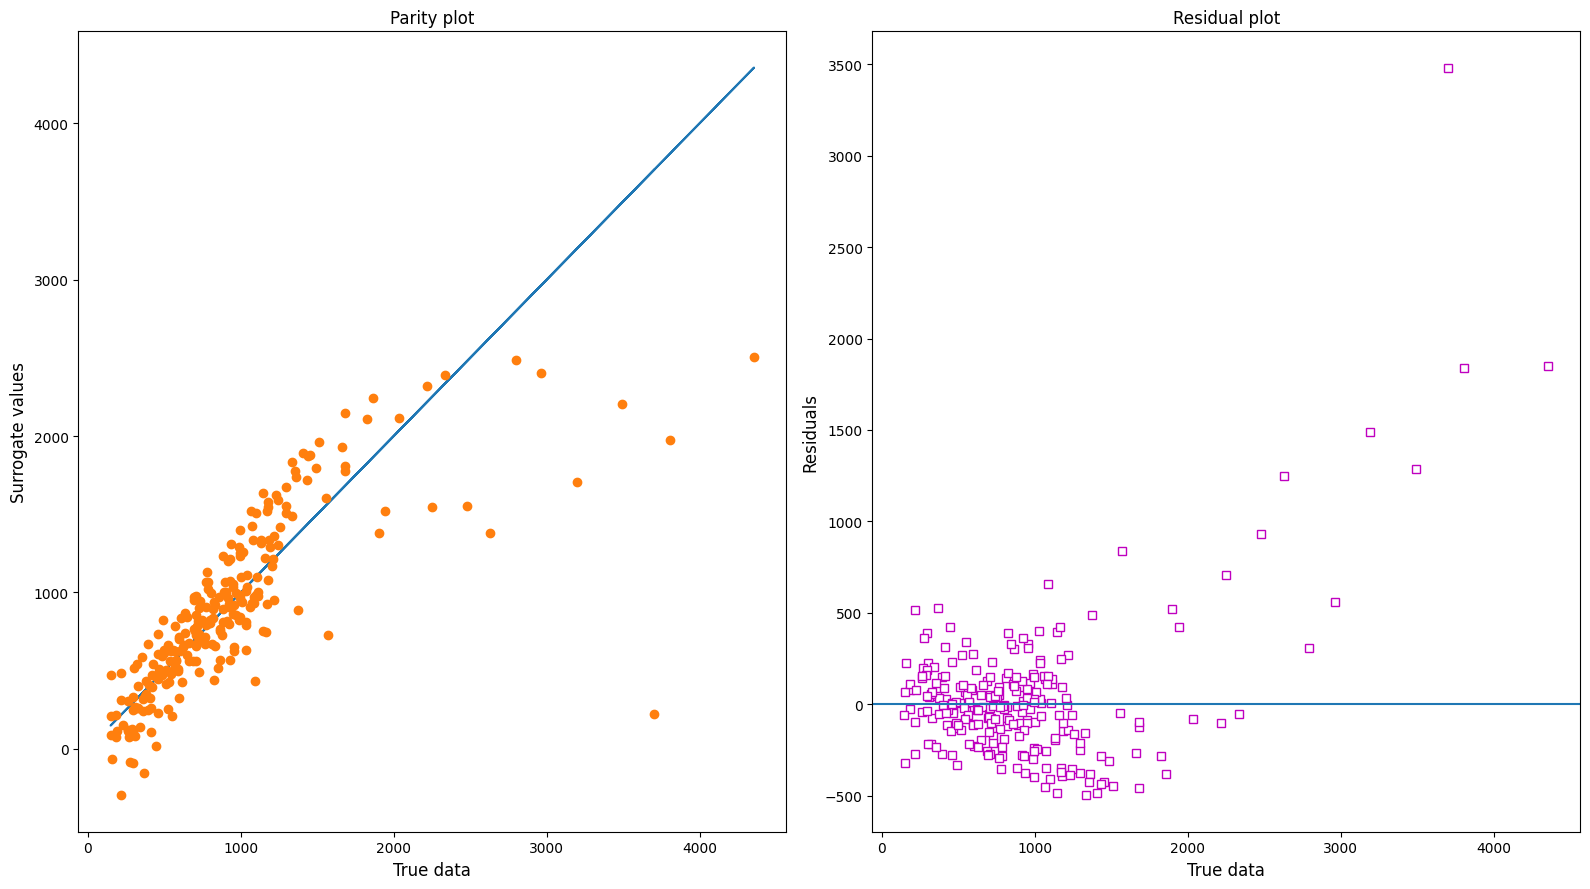

In [ ]:
poly_class.parity_residual_plots()

In [ ]:
import numpy as np
from idaes.core.surrogate.pysmo.radial_basis_function import RadialBasisFunctions
from idaes.core.surrogate.pysmo_surrogate import PysmoRBFTrainer, PysmoSurrogate
from io import StringIO
import contextlib
# https://github.com/IDAES/examples-pse/blob/main/src/Examples/SurrMod/FlowsheetOptimization/PySMO_flowsheet_optimization.ipynb

input_labels = ['pressure', 'enthalpy', 'flow']
output_labels = ['outlet_pressure', 'outlet_enthalpy']

trainer = PysmoRBFTrainer(input_labels=input_labels, output_labels=output_labels, training_dataframe=df)
trainer.config.basis_function = 'gaussian'


# Train surrogate (calls PySMO through IDAES Python wrapper)
stream = StringIO()
with contextlib.redirect_stdout(stream):
    rbf_train = trainer.train_surrogate()

# display first 50 lines and last 50 lines of output
celloutput = stream.getvalue().split('\n')
for line in celloutput[:50]:
    print(line)
print('.')
print('.')
print('.')
for line in celloutput[-50:]:
    print(line)


# create callable surrogate model
input_bounds = {'pressure': (51325, 1013250), # just using the min and max values from the training data to be the bounds, probably not the best idea but should work for now
                'enthalpy': (100, 8000),
                'flow': (1, 100000)}
rbf_surr = PysmoSurrogate(rbf_train, input_labels, output_labels, input_bounds)

# save model to JSON
model = rbf_surr.save_to_file('pysmo_rbf_surrogate.json', overwrite=True)




2024-06-20 14:50:37 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output outlet_pressure trained successfully
2024-06-20 14:51:16 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output outlet_enthalpy trained successfully


The RBF model has a much better r2 than the polynomial model, so we'll use the RBF model.
The polynomial model failed to converge/solve. We need to figure out why that was.

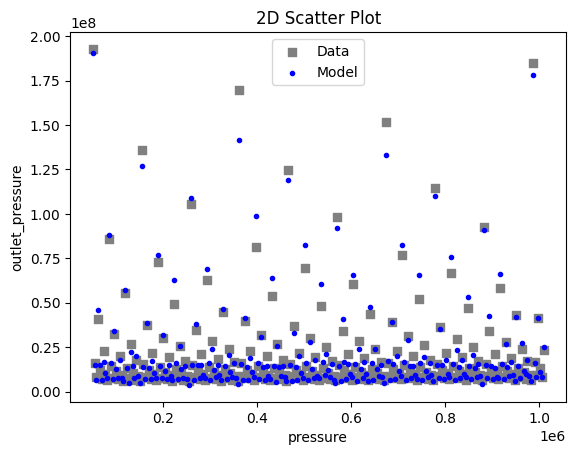

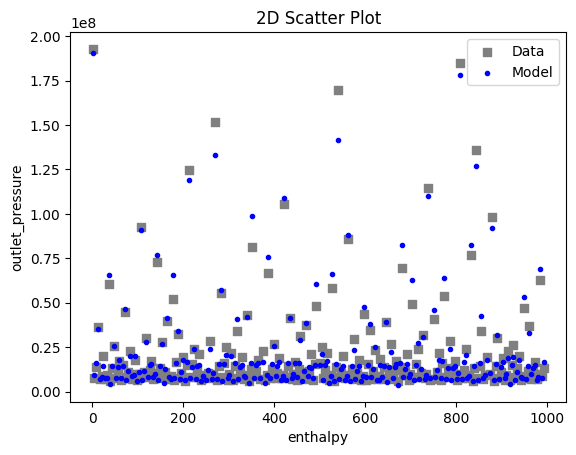

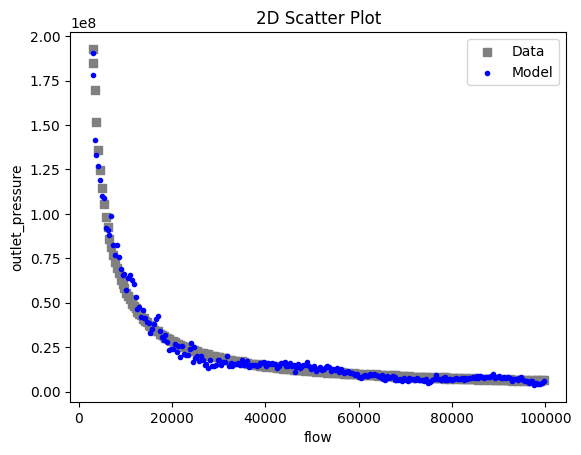

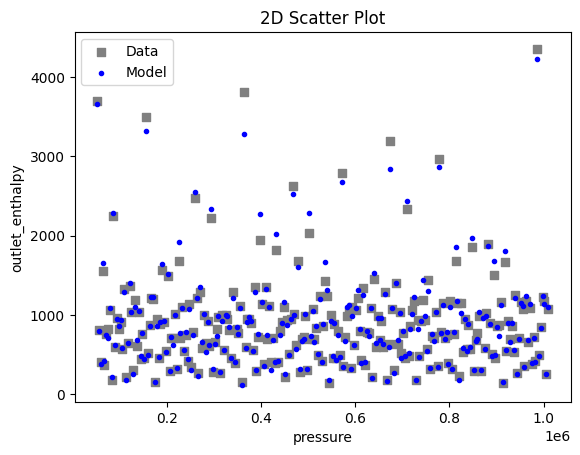

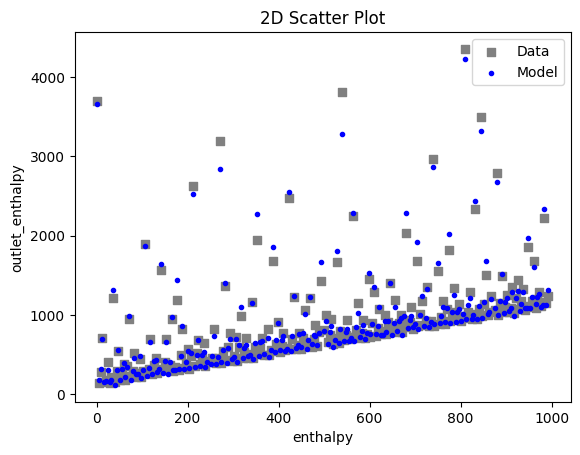

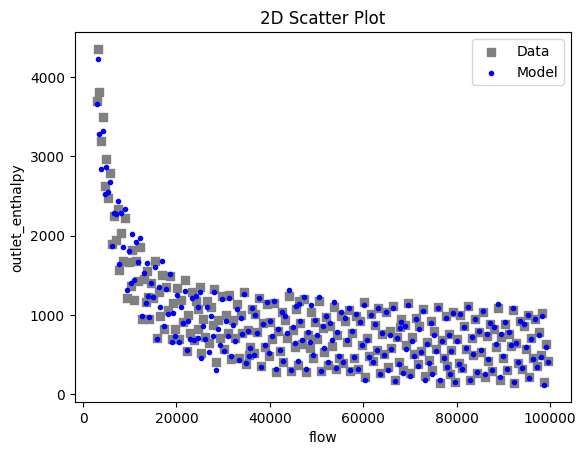

In [ ]:
# visualize with IDAES surrogate plotting tools
from idaes.core.surrogate.plotting.sm_plotter import surrogate_scatter2D, surrogate_parity, surrogate_residual
surrogate_scatter2D(rbf_surr, df, filename='pysmo_poly_train_scatter2D.pdf')
#surrogate_parity(rbf_surr, df, filename='pysmo_poly_train_scatter2D.pdf')
#surrogate_residual(rbf_surr, df, filename='pysmo_poly_train_scatter2D.pdf')

# Using the trained model in a idaes flowsheet

In [ ]:
from idaes.core.surrogate.pysmo_surrogate import PysmoSurrogate
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core.base.property_base import StateBlock

m = pyo.ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.properties = iapws95.Iapws95ParameterBlock()

# create a State block for the inlet and the outlet
m.fs.inlet_state = m.fs.properties.build_state_block()
m.fs.outlet_state = m.fs.properties.build_state_block()

# view the properties in the inlet_state block
for prop in m.fs.inlet_state.component_objects(pyo.Var):
    print(prop)

# load the pysmo model

inputs = [m.fs.inlet_state.pressure, m.fs.inlet_state.enth_mol, m.fs.inlet_state.flow_mol]
outputs = [m.fs.outlet_state.pressure, m.fs.outlet_state.enth_mol]
surrogate = PysmoSurrogate.load_from_file('pysmo_rbf_surrogate.json')
m.fs.surrogate = SurrogateBlock(concrete=True)
m.fs.surrogate.build_model(surrogate,input_vars=inputs, output_vars=outputs)
# The surrogate model predicts the outlet pressure and temperature, but does not predict the outlet flow_mol.
# We need to add a constraint to the model to set the outlet flow_mol to the inlet flow_mol

m.fs.flow_constraint = pyo.Constraint(expr=m.fs.inlet_state.flow_mol == m.fs.outlet_state.flow_mol)


2024-06-20 14:59:32 [WARNING] idaes.models.properties.general_helmholtz.helmholtz_state: Helmholtz EoS packages using Mixed phase representation ignore the 'has_phase_equilibrium' configuration argument. However, setting this to True can result in errors when constructing material balances due to only having a single phase (thus phase transfer terms cannot be constructed).
2024-06-20 14:59:32 [WARNING] idaes.models.properties.general_helmholtz.helmholtz_state: Helmholtz EoS packages using Mixed phase representation ignore the 'has_phase_equilibrium' configuration argument. However, setting this to True can result in errors when constructing material balances due to only having a single phase (thus phase transfer terms cannot be constructed).
fs.inlet_state.flow_mol
fs.inlet_state.pressure
fs.inlet_state.enth_mol
2024-06-20 14:59:32 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf

Default parameter estimation method is used.

Parameter estimation method:  algebra

In [ ]:
# Now the surrogate model is done! we can try set the inlet conditions and predict the outlet
# pressure and temperature

m.fs.inlet_state.pressure.fix(101325)
m.fs.inlet_state.enth_mol.fix(100)
m.fs.inlet_state.flow_mol.fix(1000)

# solve the model
solver = pyo.SolverFactory('ipopt')
solver.solve(m, tee=True)
print(f'outlet pressure: {pyo.value(m.fs.outlet_state.pressure[0])}, outlet temperature: {pyo.value(m.fs.outlet_state.enth_mol[0])}, outlet flow: {pyo.value(m.fs.outlet_state.flow_mol[0])}')

WARNING (W1002): Setting Var 'fs.inlet_state.flow_mol' to a numeric value
`100` outside the bounds (3000, 100000).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002


InfeasibleConstraintException: model contains a trivially infeasible variable 'fs.inlet_state.flow_mol' (fixed value 100 outside bounds [3000, 100000]).